# Extra Credit Project for Principles of Urban Informatics 
##  Author : Le Xu. lx565




# IDEA 1:
## Night has more people go out/dine out and trains are getting slower or less, so night has more long trips than the day.
## Data: Taxi ridership data, Taxi and Limousine Commission  
### https://nyc.gov

# NULL HYPOTHESIS:
## The ratio of numbers of $daytime$ long taxi trips over total numbers of $daytime$ taxi trips is same or higher than the ratio of numbers of $nighttime$ long taxi trips over total numbers of $nighttime$ trips.

# _$H_0$_ : $\frac{Day Long Trips}{Total Day Trip}>= \frac{Night Long Trips}{Total Night Trips}$
# _$H_1$_ : $\frac{Day Long Trips}{Total Day Trip} < \frac{Night Long Trips}{Total Night Trips}$


## I will use a significance level  $\alpha=0.05$

#### Range of hours for this analysis. Day time (from 6:00 to 18:00) Night time (from 18:00 to 6:00)`

#### which means i want the probability of getting a result at least as significant as mine to be less then 5%

## I am starting with a single month of data: reading data from TAXI trip data csv file from Jan 2016
what I want is the date and time of the beginning of each trip AND the trip_distance. pandas has an easy method to read csv files, and an easy method to convert strings to dates.


## Import initial libraries

In [611]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
import matplotlib.pylab as plt
import pysal as ps
import shapely
from IPython.display import Image
import seaborn as sns
import scipy


In [612]:
np.random.seed(123) # for reproducibility

## Load Yellow Cab data on 2016-01

In [637]:
taxi_data=DataFrame.from_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv")

In [644]:
data = taxi_data[["tpep_pickup_datetime","tpep_dropoff_datetime", "trip_distance", "fare_amount", "total_amount"]]
data.reset_index(inplace= True)

In [645]:
data.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount
10906853,2,2016-01-31 23:30:32,2016-01-31 23:38:18,2.2,8.5,9.80
10906854,1,2016-01-05 00:15:55,2016-01-05 00:16:06,0.0,2.5,3.80
10906855,1,2016-01-05 06:12:46,2016-03-19 20:45:50,1.4,7.5,8.80
10906856,1,2016-01-05 06:21:44,2016-03-28 12:54:26,2.1,11.5,14.75
10906857,1,2016-01-05 06:15:21,2016-01-05 06:15:36,0.0,52.0,58.34


In [646]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10906858 entries, 0 to 10906857
Data columns (total 6 columns):
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
trip_distance            float64
fare_amount              float64
total_amount             float64
dtypes: float64(3), int64(1), object(2)
memory usage: 499.3+ MB


# Explore the data

## Since the data is huge, so I will use a subset to do this analysis

In [647]:
index = np.random.choice(data.index, 20000, replace=True)
data_sub = data.iloc[index]

In [648]:
data_sub.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount
2116335,1,2016-01-10 20:46:53,2016-01-10 20:53:08,1.20,6.5,9.35
1566637,1,2016-01-07 20:40:39,2016-01-07 20:49:26,1.00,7.5,9.80
1233463,1,2016-01-05 20:11:07,2016-01-05 20:26:34,3.80,15.0,16.30
7243099,2,2016-01-29 23:54:03,2016-01-30 00:04:54,2.30,10.0,11.30
10246386,2,2016-01-07 22:37:36,2016-01-07 22:47:02,2.07,9.5,12.96


## Drop rows where pickup time and dropoff time is the same. 

In [649]:
data_sub = data_sub[data_sub.tpep_pickup_datetime < data_sub.tpep_dropoff_datetime]

## Drop rows where trip distance and fare amount is zero.

In [650]:
data_sub = data_sub[data_sub.trip_distance > 0]
data_sub = data_sub[data_sub.fare_amount > 0]

## Plot to have a general view of the data allocation

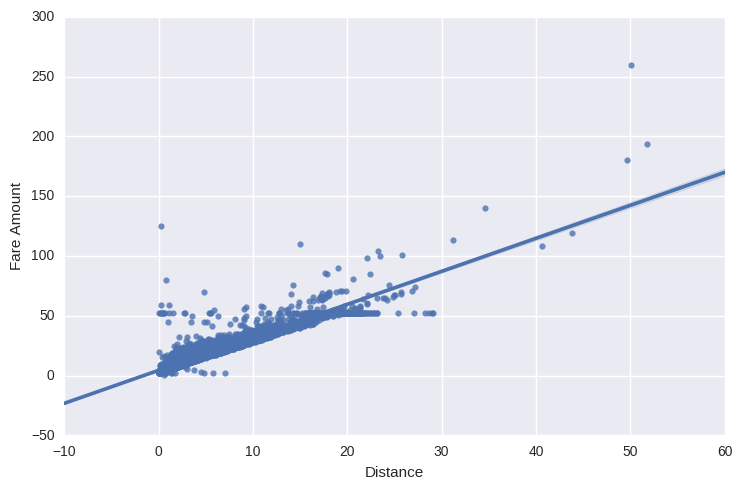

In [651]:
# explore the data
g = sns.pairplot(data_sub, x_vars = "trip_distance", y_vars = "fare_amount", 
                 size = 5, aspect = 1.5, kind = "reg")
plt.xlabel("Distance")
plt.ylabel("Fare Amount")

## This plot is just to help me to get a general idea of the data. Also to see if there is any abnormality.

## Identify Outliers : see if there are several extreme points

In [652]:
data_sub.fare_amount.nlargest(5)

8170341     260.0
5633318     194.0
5079510     180.0
9940537     140.0
10412527    125.0
Name: fare_amount, dtype: float64

In [653]:
data_sub.trip_distance.nlargest(5)

5633318    51.73
8170341    50.10
5079510    49.65
9317469    43.84
2114924    40.60
Name: trip_distance, dtype: float64

## Conclusion: No outliers 
---

## Lets separate day from night to test the hypotheses.


#### I am choosing day/night cuts as follows:
##### Day time (from 6:00 to 18:00), Night time (from 18:00 to 6:00)`



In [654]:
# convert the time into datetime
data_sub["time"] = pd.to_datetime(data_sub.tpep_pickup_datetime)

In [655]:
data_sub.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,time
2116335,1,2016-01-10 20:46:53,2016-01-10 20:53:08,1.20,6.5,9.35,2016-01-10 20:46:53
1566637,1,2016-01-07 20:40:39,2016-01-07 20:49:26,1.00,7.5,9.80,2016-01-07 20:40:39
1233463,1,2016-01-05 20:11:07,2016-01-05 20:26:34,3.80,15.0,16.30,2016-01-05 20:11:07
7243099,2,2016-01-29 23:54:03,2016-01-30 00:04:54,2.30,10.0,11.30,2016-01-29 23:54:03
10246386,2,2016-01-07 22:37:36,2016-01-07 22:47:02,2.07,9.5,12.96,2016-01-07 22:37:36


In [656]:
mask_day = (data_sub.time.dt.hour >= 6) & (data_sub.time.dt.hour < 18)

In [657]:
data_sub_day = data_sub[mask_day]
data_sub_night = data_sub[~mask_day]

In [658]:
data_sub_day.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,time
8187402,2,2016-01-20 15:29:43,2016-01-20 15:43:23,1.39,9.5,12.36,2016-01-20 15:29:43
3322221,2,2016-01-16 16:19:39,2016-01-16 16:31:06,2.02,9.5,12.36,2016-01-16 16:19:39
10789718,2,2016-01-10 13:50:26,2016-01-10 13:57:51,1.34,7.5,9.96,2016-01-10 13:50:26
4397291,2,2016-01-11 08:36:07,2016-01-11 08:41:45,0.97,5.5,7.30,2016-01-11 08:36:07
8116223,2,2016-01-20 11:42:44,2016-01-20 11:58:14,4.89,16.5,22.84,2016-01-20 11:42:44


In [659]:
data_sub_night.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount,time
2116335,1,2016-01-10 20:46:53,2016-01-10 20:53:08,1.20,6.5,9.35,2016-01-10 20:46:53
1566637,1,2016-01-07 20:40:39,2016-01-07 20:49:26,1.00,7.5,9.80,2016-01-07 20:40:39
1233463,1,2016-01-05 20:11:07,2016-01-05 20:26:34,3.80,15.0,16.30,2016-01-05 20:11:07
7243099,2,2016-01-29 23:54:03,2016-01-30 00:04:54,2.30,10.0,11.30,2016-01-29 23:54:03
10246386,2,2016-01-07 22:37:36,2016-01-07 22:47:02,2.07,9.5,12.96,2016-01-07 22:37:36


# What is the threshold for long trip and short trip?
## Since the distance and fare are in linear relationship, so the higher fare means longer distance in general.
### I decide to choose 2 sigma, the mean and stardand deviation of the time series can be used to set a 2-sigma threshold


In [660]:
mean= np.mean(data_sub.fare_amount)
std = np.std(data_sub.fare_amount)

In [661]:
print ("mean fare amount by day {:.2f}".format(mean))
print ("stdev fare amount by day {:.2f}".format(std))
thresholds = [mean + 2 * std, mean - 2 *std]
print ("2-sigma thresholds upper limit is {:.2f}".format(*thresholds))

mean fare amount by day 12.53
stdev fare amount by day 10.69
2-sigma thresholds upper limit is 33.90


## Let's set 33.24 dollars as the threshold for long trip and short trip
---

In [662]:
data_sub_day_l = data_sub_day[data_sub_day.fare_amount >= 33.24]

In [663]:
data_sub_night_l = data_sub_night[data_sub_night.fare_amount >= 33.24]

## Let's investigate "what time of the day has the better chance to have long trip"

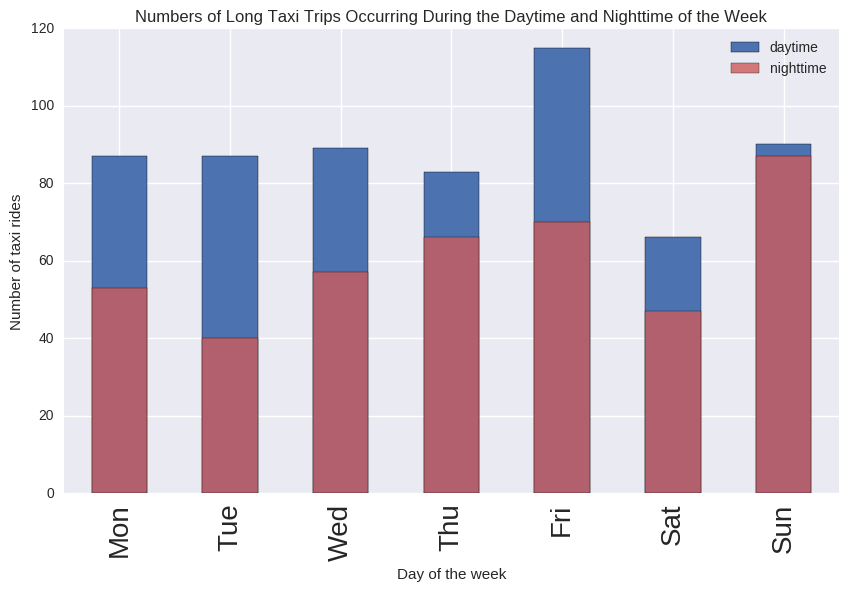

In [664]:
f, ax = plt.subplots(figsize = (10,6))
norm_d = 1
norm_n = 1
counts_d = data_sub_day.time.groupby(data_sub_day.time.dt.weekday).count()
counts_n = data_sub_night.time.groupby(data_sub_night.time.dt.weekday).count()
counts_d_l = data_sub_day_l.time.groupby(data_sub_day_l.time.dt.weekday).count()
counts_n_l = data_sub_night_l.time.groupby(data_sub_night_l.time.dt.weekday).count()
ax = (counts_d_l/norm_d).plot(kind = "bar", label= "daytime", stacked=True)
ax = (counts_n_l/norm_n).plot(kind = "bar", label= "nighttime", color='IndianRed', stacked=True, alpha = 0.8)
                                                                                       
tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
plt.legend(fontsize = 10)
ax.set_ylabel ("Number of taxi rides")
ax.set_xlabel ("Day of the week")
ax.set_title ("Numbers of Long Taxi Trips Occurring During the Daytime and Nighttime of the Week")

## Figure 1: Distribution of Long Taxi trip counts by day and night in January 2016, absolute counts
### We can see only on Saturday, the night trips are more than the day trips.

## Since the absolute counts has error because it follows poisson distribution.

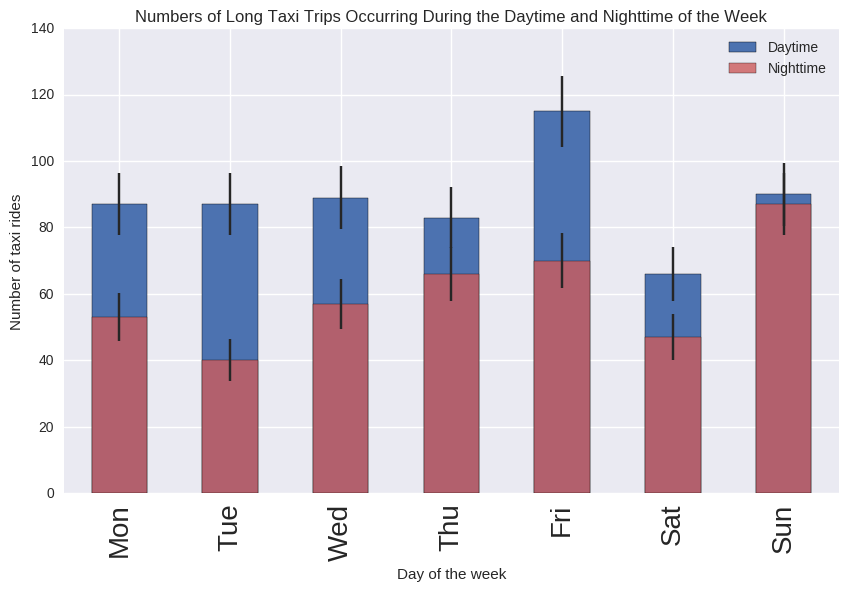

In [665]:
error_d = np.sqrt(counts_d_l)
error_n = np.sqrt(counts_n_l)

f, ax = plt.subplots(figsize = (10,6))
norm_d = 1
norm_n = 1

ax=((counts_d_l) / norm_d).plot(kind="bar", yerr=[((error_d) / norm_d, (error_d) / norm_d)], label='Daytime')

ax=((counts_n_l) / norm_n).plot(kind="bar",color='IndianRed', yerr=[((error_n) / norm_n, (error_n) / norm_n)], 
                              label='Nighttime', alpha = 0.8)

# ax = (count_d/norm_d).plot(kind = "bar", label= "daytime", stacked=True)
# ax = (count_n/norm_n).plot(kind = "bar", label= "nighttime", color='IndianRed', stacked=True, alpha = 0.8)
                                                                                       
tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
plt.legend(fontsize = 10)
ax.set_ylabel ("Number of taxi rides")
ax.set_xlabel ("Day of the week")
ax.set_title ("Numbers of Long Taxi Trips Occurring During the Daytime and Nighttime of the Week")


## Figure 2: Distribution of Long Taxi trip counts by daytime and nighttime in January 2016, absolute counts, with statistical errors

     Becuase it is very hard to compare absolute numbers. Ratios (or proportions) are more ameable to comparison, 
     so let's _normalize_ the distribution of daytime long trips, and that of nighttime long trips, 
     i.e. devide them by the total number of long trips for that time period.

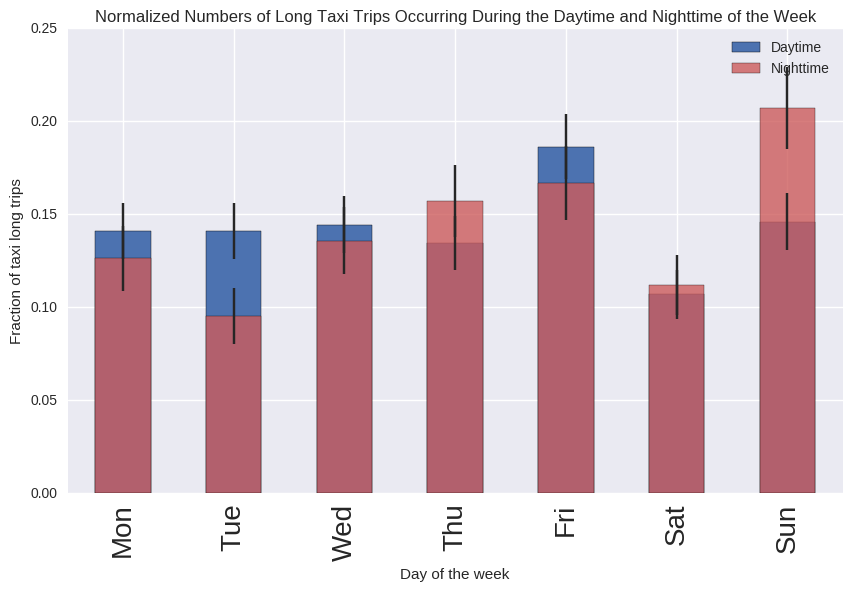

In [666]:
error_d = np.sqrt(counts_d_l)
error_n = np.sqrt(counts_n_l)

f, ax = plt.subplots(figsize = (10,6))
norm_d = counts_d_l.sum()
norm_n = counts_n_l.sum()


ax=((counts_d_l) / norm_d).plot(kind="bar", yerr=[((error_d) / norm_d, (error_d) / norm_d)], label='Daytime')

ax=((counts_n_l) / norm_n).plot(kind="bar",color='IndianRed', yerr=[((error_n) / norm_n, (error_n) / norm_n)], 
                              label='Nighttime', alpha = 0.8)

# ax = (count_d/norm_d).plot(kind = "bar", label= "daytime", stacked=True)
# ax = (count_n/norm_n).plot(kind = "bar", label= "nighttime", color='IndianRed', stacked=True, alpha = 0.8)
                                                                                       
tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
plt.legend(fontsize = 10)
ax.set_ylabel ("Fraction of taxi long trips")
ax.set_xlabel ("Day of the week")

ax.set_title ("Normalized Numbers of Long Taxi Trips Occurring During the Daytime and Nighttime of the Week")


## Figure 3: Distribution of Long taxi trip counts by daytime and nighttime in January 2016, absolute counts, with statistical errors, Normalized.
## It is interesting to see that: After normalization, nighttime has the longer trips during the four days out of the week, which as Tuesday, Friday, Saturday, and Sunday. The Thursday is almost equal on both time period. 
___

# Test of proportions

# _$H_0$_ : $\frac{Day Long Trips}{Total Day Trip}>= \frac{Night Long Trips}{Total Night Trips}$

## The statistics is: 
### $z = \frac{(p_0 - p_1)}{SE} $
### $p =\frac{p_0  n_0 + p_1  n_1}{n_0+n_1}$
### $SE = \sqrt{ p  ( 1 - p )  (\frac{1}{n_0} + \frac{1}{n_1}) }$
## and in this notation 
### $p_0 = \frac{Night Long Trips}{Total Night Trips}$
### and 
### $p_1 = \frac{Day Long Trips}{Total Day Trip}$

In [667]:
# total night trips
p0 = counts_n_l.sum()/counts_n.sum()
p1 = counts_d_l.sum()/counts_d.sum()
n0 = counts_n.sum()
n1 = counts_d.sum()

p = lambda p0, p1, n0, n1: (p0 * n0 + p1 * n1) / (n0 + n1)
se = lambda p, n0, n1: np.sqrt(p * (1 - p) * (1.0 / n0 + 1.0 / n1)) #standard error
zscore = lambda p0, p1, s : (p0 - p1) / s

In [668]:
s = se(p(p0, p1, n0, n1), n0, n1)
# print (sp_stdev_mw)
z = zscore(p0, p1, s)
print ("The z statistics is %.2f"%np.abs(z)) 


The z statistics is 3.55


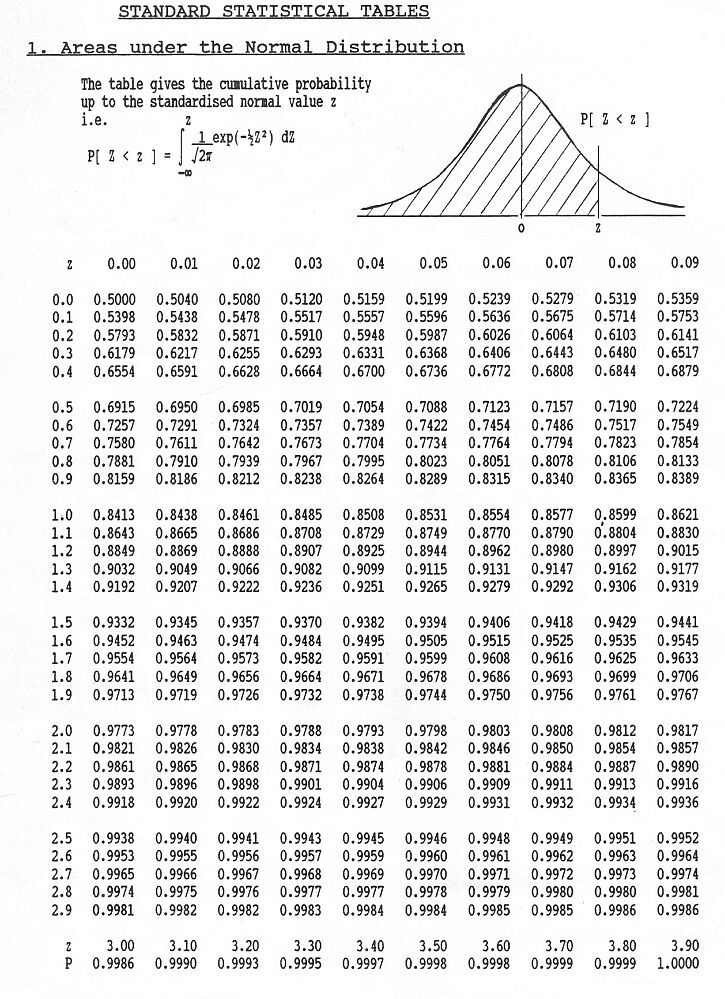

In [669]:
# let's read the p value from the z score table
Image('http://intersci.ss.uci.edu/wiki/images/3/3a/Normal01.jpg')

In [670]:
p_2y = 1 - 0.9854

In [ ]:
p_2y

In [671]:
alpha = 0.05
def result_report(pvalue):
    """
    this function is to report the result of z score p value,
    if it is smaller than the critical value
    
    """
    print ('Is the p value {0:.2f} smaller than the critical value {1:.2f}?'.format(pvalue,alpha))
    if pvalue < alpha:
        print ("Yes!")
    else: print ("NO!")
    print ('The Null hypothesis is {}'.format('rejected' if pvalue < alpha else 'not rejected') )
        
    
        

In [672]:
result_report(p_2y)

Is the p value 0.01 smaller than the critical value 0.05?
Yes!
The Null hypothesis is rejected


# CONCLUSION ON THIS STATISTICAL TEST :  
# NULL HYPOTHESIS IS REJECTED.
### The ratio of numbers of Taxi longer trips over total numbers of trips occurred during the daytime is NOT same or higher than the ratio of numbers of Taxi longer trip over total numbers of trips occurred during the nighttime.
## Our initial idea is surported by the test, as:
## Nighttime has better chance of getting long taxi trip for taxi drivers than daytime.

---

# Check the robustness of our answer with another taxi dataset. 2016/06
### Lets see if our test holds for the warmer weather, when people are more willing to go out at night

In [673]:
taxi_data = DataFrame.from_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-06.csv")

In [674]:
data_summer = taxi_data
data_summer.head(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
VendorID,,,,,,,,,,,,,,,,,,
2,2016-06-09 21:06:36,2016-06-09 21:13:08,2,0.79,-73.983360,40.760937,1,N,-73.977463,40.753979,2,6.0,0.5,0.5,0.00,0.0,0.3,7.30
2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.0,0.5,0.5,4.00,0.0,0.3,27.30
2,2016-06-09 21:06:36,2016-06-09 21:13:10,1,1.26,-73.994316,40.751072,1,N,-74.004234,40.742168,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
2,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.39,-73.982361,40.773891,1,N,-73.929466,40.851540,1,26.0,0.5,0.5,1.00,0.0,0.3,28.30
2,2016-06-09 21:06:36,2016-06-09 21:23:23,1,3.10,-73.987106,40.733173,1,N,-73.985909,40.766445,1,13.5,0.5,0.5,2.96,0.0,0.3,17.76
2,2016-06-09 21:06:36,2016-06-09 21:19:21,1,2.17,-73.995201,40.739491,1,N,-73.993202,40.762642,1,10.5,0.5,0.5,2.36,0.0,0.3,14.16
2,2016-06-09 21:06:36,2016-06-09 21:30:13,5,6.02,-73.980476,40.741680,1,N,-73.902962,40.748741,2,21.5,0.5,0.5,0.00,0.0,0.3,22.80
1,2016-06-09 21:06:37,2016-06-09 21:16:47,1,1.40,-73.985703,40.746742,1,N,-73.982506,40.762772,1,8.5,0.5,0.5,1.95,0.0,0.3,11.75
1,2016-06-09 21:06:37,2016-06-09 21:15:44,1,1.20,-73.984276,40.775009,1,N,-73.968498,40.766430,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30


In [675]:
data_summer = data_summer.reset_index()

In [676]:
data_summer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11135470 entries, 0 to 11135469
Data columns (total 19 columns):
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int64
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: float64(12), int64(4), object(3)
memory usage: 1.6+ GB


In [677]:
index = np.random.choice(data_summer.index, 20000, replace=True)
data_summer_sub = data_summer.iloc[index]

## As we did for the January set, we clear data before analysis 

In [678]:
data_summer_sub = data_summer_sub[data_summer_sub.tpep_pickup_datetime < data_summer_sub.tpep_dropoff_datetime]
data_summer_sub = data_summer_sub[data_summer_sub.trip_distance > 0]
data_summer_sub = data_summer_sub[data_summer_sub.fare_amount > 0]

In [679]:
data_summer_sub.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
1770135,2,2016-06-05 00:01:20,2016-06-05 00:18:10,1,3.35,-73.986526,40.747761,1,N,-73.948280,40.770470,1,14.0,0.5,0.5,3.06,0.0,0.3,18.36
4268698,2,2016-06-09 18:26:55,2016-06-09 18:42:41,6,1.88,-73.967728,40.752121,1,N,-73.990166,40.741734,1,11.0,1.0,0.5,3.84,0.0,0.3,16.64
449948,1,2016-06-01 21:53:00,2016-06-01 22:07:41,1,1.50,-73.977654,40.746582,1,N,-73.963646,40.765968,1,10.5,0.5,0.5,2.35,0.0,0.3,14.15
6990166,1,2016-06-19 15:03:09,2016-06-19 15:05:59,1,0.40,-73.941101,40.813934,1,N,-73.945488,40.807911,2,4.0,0.0,0.5,0.00,0.0,0.3,4.80
8294416,1,2016-06-24 22:38:49,2016-06-24 22:51:00,1,1.20,-74.006950,40.730740,1,N,-73.990074,40.726498,1,8.5,0.5,0.5,2.45,0.0,0.3,12.25


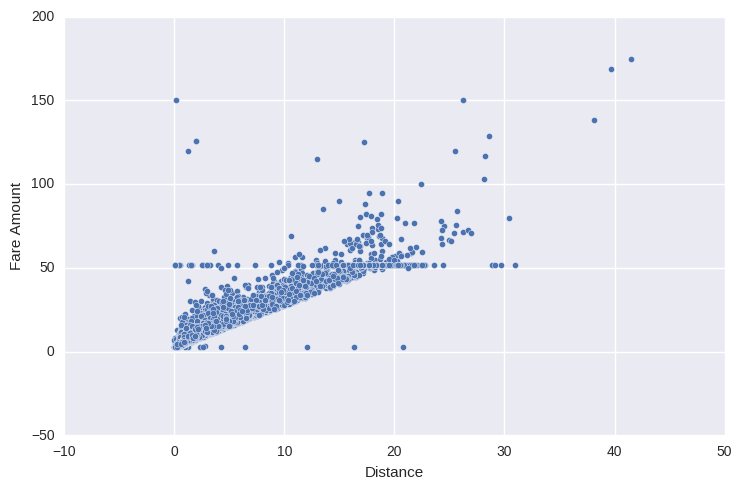

In [680]:
g = sns.pairplot(data_summer_sub, x_vars = "trip_distance", y_vars = "fare_amount", size = 5, aspect = 1.5)
plt.xlabel("Distance")
plt.ylabel("Fare Amount")

### check outliers:

In [681]:
data_summer_sub.fare_amount.nlargest(5)

2326426    175.0
4741246    169.0
424819     150.0
6774514    150.0
1311357    138.5
Name: fare_amount, dtype: float64

In [682]:
data_summer_sub.trip_distance.nlargest(5)

2326426    41.5
4741246    39.7
1311357    38.1
7327717    31.0
8779729    30.4
Name: trip_distance, dtype: float64

## Separate the data by day and night:


In [683]:
data_summer_sub["time"] = pd.to_datetime(data_summer_sub.tpep_pickup_datetime)

In [684]:
mask_day = (data_summer_sub.time.dt.hour >= 6) & (data_summer_sub.time.dt.hour < 18)

In [685]:
data_summer_d = data_summer_sub[mask_day]
data_summer_n = data_summer_sub[~mask_day]

## Threshold setting: 2 sigma

In [686]:
mean= np.mean(data_summer_sub.fare_amount)
std = np.std(data_summer_sub.fare_amount)

In [687]:
print ("mean fare amount by day {:.2f}".format(mean))
print ("stdev fare amount by day {:.2f}".format(std))
thresholds = [mean + 2 * std, mean - 2 *std]
print ("2-sigma thresholds upper limit is {:.2f}".format(*thresholds))

mean fare amount by day 13.35
stdev fare amount by day 11.06
2-sigma thresholds upper limit is 35.46


## Let's set 35.94 dollars as the threshold for long trip and short trip for this dataset! Which is higher than the 2016-01 dataset 33.24 dollars

In [688]:
data_summer_d_l = data_summer_d[data_summer_d.fare_amount >= 35.94]
data_summer_n_l = data_summer_n[data_summer_n.fare_amount >= 35.94]

## Ready to investigate!

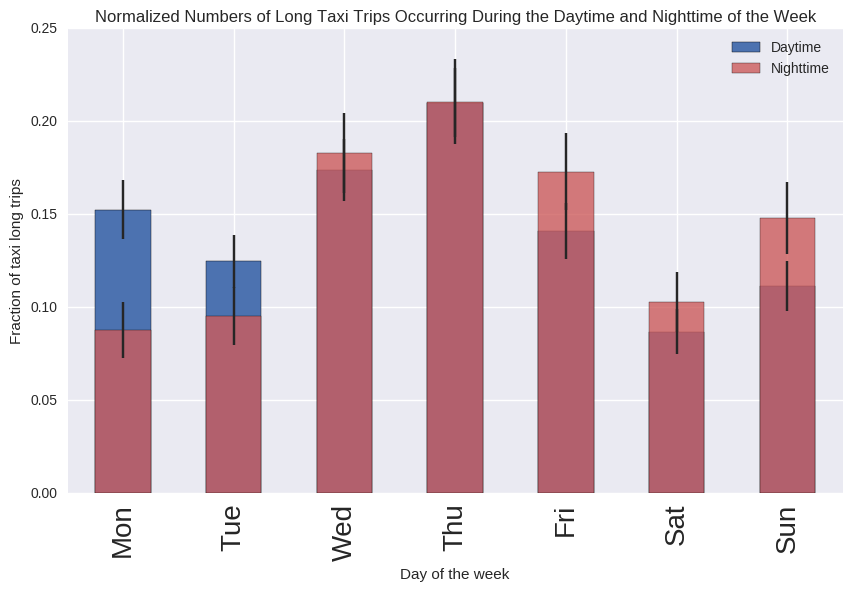

In [689]:
counts_d = data_summer_d.time.groupby(data_summer_d.time.dt.weekday).count()
counts_n = data_summer_n.time.groupby(data_summer_n.time.dt.weekday).count()

counts_d_l = data_summer_d_l.time.groupby(data_summer_d_l.time.dt.weekday).count()
counts_n_l = data_summer_n_l.time.groupby(data_summer_n_l.time.dt.weekday).count()

error_d = np.sqrt(counts_d_l)
error_n = np.sqrt(counts_n_l)

f, ax = plt.subplots(figsize = (10,6))
norm_d = counts_d_l.sum()
norm_n = counts_n_l.sum()


ax=((counts_d_l) / norm_d).plot(kind="bar", yerr=[((error_d) / norm_d, (error_d) / norm_d)], label='Daytime')

ax=((counts_n_l) / norm_n).plot(kind="bar",color='IndianRed', yerr=[((error_n) / norm_n, (error_n) / norm_n)], 
                              label='Nighttime', alpha = 0.8)

# ax = (count_d/norm_d).plot(kind = "bar", label= "daytime", stacked=True)
# ax = (count_n/norm_n).plot(kind = "bar", label= "nighttime", color='IndianRed', stacked=True, alpha = 0.8)
                                                                                       
tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
plt.legend(fontsize = 10)
ax.set_ylabel ("Fraction of taxi long trips")
ax.set_xlabel ("Day of the week")

ax.set_title ("Normalized Numbers of Long Taxi Trips Occurring During the Daytime and Nighttime of the Week")

## Figure 3: Distribution of Long taxi trip counts by daytime and nighttime in June 2016, absolute counts, with statistical errors, Normalized.
## Nighttime has the longer trips during the weekend out of the week, which are Friday, Saturday, and Sunday. So during the weekdays, daytime has more long trips.

----

## TEST:

In [690]:
p0 = counts_n_l.sum()/counts_n.sum()
p1 = counts_d_l.sum()/counts_d.sum()
n0 = counts_n.sum()
n1 = counts_d.sum()

p = lambda p0, p1, n0, n1: (p0 * n0 + p1 * n1) / (n0 + n1)
se = lambda p, n0, n1: np.sqrt(p * (1 - p) * (1.0 / n0 + 1.0 / n1)) #standard error
zscore = lambda p0, p1, s : (p0 - p1) / s


s = se(p(p0, p1, n0, n1), n0, n1)
# print (sp_stdev_mw)
z = zscore(p0, p1, s)
print ("The z statistics is %.2f"%np.abs(z)) 


The z statistics is 4.85


## The largest number reported in z stats tables is typically 3, which gives a p value very small. Here the z stats score we reached from our summer dataset is 6.17, which is significantly large compares to 3. As the assumed p value is much smaller than my alpha a = 0.05, so we reject the Null again.

# Our hypothesis is robost to seasonality.

# In order to give a better interpretation on the analysis, we have to understand the limitation on the dataset, because we just used a subset (20000 out of 1m+), and just used two months total. After all, I would suggest that Taxi drivers should choose to work in the day time for weekdays and nighttime for weekends in order to make more money.
---

# IDEA 2:
# How bad weather (rain/snow) could affect taxi ridership?
### Data 1 : Taxi ridership data, Taxi and Limousine Commission
#### https://nyc.gov

### Data 2: Daily Central Park weather data, National Climatic Data Center
#### https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094728/detail


## Load the weather data from 2016-1-1 to 2016-6-31  which I pre-downloaded to the github link. https://github.com/lx565/PUI-Extra-Credit/tree/master/Data

In [691]:
path = "https://raw.githubusercontent.com/lx565/PUI-Extra-Credit/master/Data/weather%20data%202016_1_1%20-%206_31.csv"

In [692]:
weather = pd.read_csv(path)

In [709]:
weather.info() # take a look 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 5 columns):
PRCP        213 non-null float64
SNWD        213 non-null float64
SNOW        213 non-null float64
TMIN        213 non-null int64
DATETIME    213 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 8.4 KB


In [694]:
weather['DATETIME'] = pd.to_datetime(weather['DATE'].astype(str), format='%Y%m%d')

In [695]:
weather.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,PRCP,SNWD,SNOW,TAVG,TMAX,TMIN,DATETIME
0,GHCND:USW00094728,NY CITY CENTRAL PARK NY US,39.6,40.77889,-73.96917,20160101,0.0,0.0,0.0,-9999,42,34,2016-01-01
1,GHCND:USW00094728,NY CITY CENTRAL PARK NY US,39.6,40.77889,-73.96917,20160102,0.0,0.0,0.0,-9999,40,32,2016-01-02
2,GHCND:USW00094728,NY CITY CENTRAL PARK NY US,39.6,40.77889,-73.96917,20160103,0.0,0.0,0.0,-9999,45,35,2016-01-03
3,GHCND:USW00094728,NY CITY CENTRAL PARK NY US,39.6,40.77889,-73.96917,20160104,0.0,0.0,0.0,-9999,36,14,2016-01-04
4,GHCND:USW00094728,NY CITY CENTRAL PARK NY US,39.6,40.77889,-73.96917,20160105,0.0,0.0,0.0,-9999,29,11,2016-01-05


In [696]:
weather = weather.iloc[:, (6, 7, 8, -2, -1)]
weather.head()

,PRCP,SNWD,SNOW,TMIN,DATETIME
0,0.0,0.0,0.0,34,2016-01-01
1,0.0,0.0,0.0,32,2016-01-02
2,0.0,0.0,0.0,35,2016-01-03
3,0.0,0.0,0.0,14,2016-01-04
4,0.0,0.0,0.0,11,2016-01-05


# Since I started with the Jan and June months 2016 for Taxi data, so I will use those two months again for the weather data in order to investigate the relationship of weather and taxi riderships.


In [697]:
weather_jan = weather[weather.DATETIME.dt.month == 1]

In [698]:
weather_june = weather[weather.DATETIME.dt.month == 6]

## Special term: SNWD means snow depths
## Let's find the days either rain or snow or have snow on the ground

In [699]:
badweather_jan = weather_jan[(weather_jan.PRCP > 0 )| (weather_jan.SNWD > 0)|(weather_jan.SNOW > 0)] 
badweather_jan

,PRCP,SNWD,SNOW,TMIN,DATETIME
9,1.80,0.0,0.0,40,2016-01-10
15,0.24,0.0,0.0,42,2016-01-16
16,0.05,0.0,0.4,30,2016-01-17
21,0.01,0.0,0.2,21,2016-01-22
22,2.31,5.9,27.3,24,2016-01-23
23,0.00,22.0,0.0,20,2016-01-24
24,0.00,18.9,0.0,28,2016-01-25
25,0.00,16.9,0.0,38,2016-01-26
26,0.00,9.1,0.0,34,2016-01-27
27,0.00,5.9,0.0,32,2016-01-28


## There were 13 days had bad weather or snow in Jan 2016


# Since June would not likely have snow, so we only investigate precipitation days for June. 


In [700]:
badweather_june = weather_june[weather_june.PRCP > 0]
badweather_june

,PRCP,SNWD,SNOW,TMIN,DATETIME
154,0.04,0.0,0.0,63,2016-06-03
155,0.40,0.0,0.0,66,2016-06-04
156,0.91,0.0,0.0,65,2016-06-05
159,0.45,0.0,0.0,52,2016-06-08
167,0.22,0.0,0.0,65,2016-06-16
178,0.45,0.0,0.0,67,2016-06-27
179,0.12,0.0,0.0,68,2016-06-28
180,0.01,0.0,0.0,67,2016-06-29


## There are only 8 rainy days in June.

## Reload the taxi data

In [701]:
taxi_jan = data_sub # January taxi data subset
taxi_june = data_summer_sub # June taxi data subset

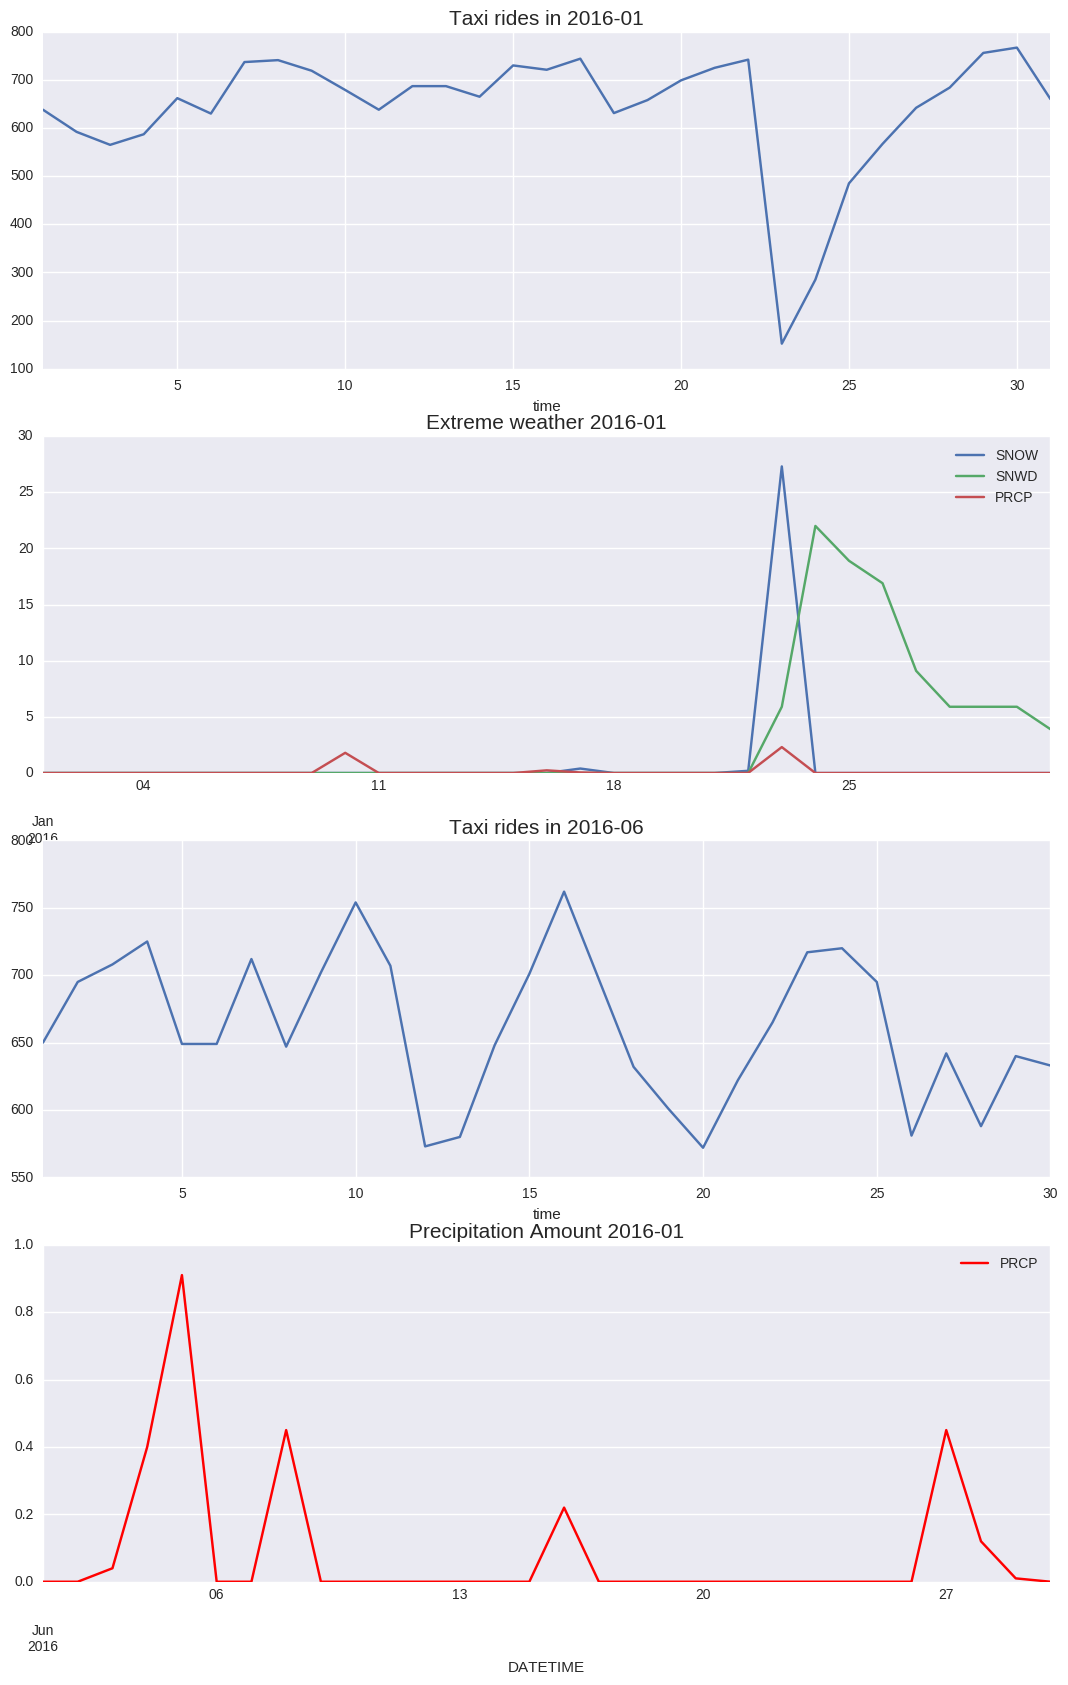

In [702]:
f, ax = plt.subplots(4, 1, figsize = (13,20))
ax1 = (taxi_jan.time.groupby(taxi_jan.time.dt.day).count()).plot(kind = "line", ax = ax[0])
ax2 = weather_jan.plot(x = "DATETIME", y = "SNOW", ax = ax[1])
ax2 = weather_jan.plot(x = "DATETIME", y = "SNWD", ax = ax[1])
ax2 = weather_jan.plot(x = "DATETIME", y = "PRCP", ax = ax[1])
ax3 = (taxi_june.time.groupby(taxi_june.time.dt.day).count()).plot(kind = "line", ax = ax[2])

ax4 = weather_june.plot(x = "DATETIME", y = "PRCP", ax = ax[3], ylim = (0,1), color = "r")

ax1.set_title("Taxi rides in 2016-01", fontsize = 15)
ax2.set_title("Extreme weather 2016-01", fontsize = 15)
ax3.set_title("Taxi rides in 2016-06", fontsize = 15)
ax4.set_title("Precipitation Amount 2016-01", fontsize = 15)



## Figure Caption: There are four plots above, the first and third bar graphs are grouped taxi rides counted by day, for Jan 2016, and June 2016. The second and fourth line plots are showing the amount of precipitation, snow, and snow depth for that month. For June, we do not have snow, only precipitation.
## We can easily identify that the drop of taxi rides on Jan 23 in the first graph, as the huge snowstorm from Jan 22's night (credit to second graph), even the snow storm just last one day or two, however, huge amount of snow was generated on the ground, so we can imagine the traffic could be difficult for following 5 days. As the snow melts, the taxi rides gradually go to normal.

# Spearman's test for correlation:
### Since spearman doesn't now require to prove gaussianity of the dataset, so it is better to use it.

In [703]:
x0 = weather_jan.SNWD # the snow days
x = taxi_jan.time.groupby(taxi_jan.time.dt.day).count() # the snow days

In [704]:
stats1 = scipy.stats.spearmanr(x0.sort_values(), x.sort_values())

In [705]:
stats2 = scipy.stats.spearmanr(x0[23:].sort_values(), x[23:].sort_values()) ## extract the snow days out of the month

In [706]:
print ("The Spearman test correlation coefficient of January weather and taxi rides is %.4f"%(stats1[0]))
print ("The Spearman test correlation coefficient of January 23-31 weather and taxi rides is %.4f"%(stats2[0]))

The Spearman test correlation coefficient of January weather and taxi rides is 0.8007
The Spearman test correlation coefficient of January 23-31 weather and taxi rides is 0.9759


## We can see the strong correlation of the snow weather and trip drop.

---

In [707]:
y0 = weather_june.PRCP # the snow days
y = taxi_june.time.groupby(taxi_june.time.dt.day).count() # the snow days

In [708]:
scipy.stats.spearmanr(y0.sort_values(), y.sort_values())

SpearmanrResult(correlation=0.77849461241708695, pvalue=4.0772468598414482e-07)

## As we can see that the SNOW DEPTH has strong correlation with numbers of taxi rides, which could due to road situation, work suspension, etc. It is not the snowing makes people's lives harder, but the snow cumulated from the snowing.
## Also, the rain seems affect the taxi rides much less, maybe people are using car services like Uber or Lyft now on the rainy days, or maybe people go out less. More discovery could be done by looking at Uber data.